# Unit13 集成學習方法 | 練習

**逢甲大學 化學工程學系 AI 課程**  
**課程名稱：AI在化工上之應用**  
**授課教師：莊曜禎 助理教授**

---

## 📋 練習目標

本練習將透過模擬複雜非線性化工製程數據，比較各種集成學習方法的性能表現。

---
## 0. 環境設定

In [ ]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit13_Overview'
SOURCE_DATA_DIR = 'chemical_process'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit13'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

print(f"\n✓ 環境設定完成！")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\data\chemical_process
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Homework
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Homework\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_Homework\figs

✓ 環境設定完成！


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

# sklearn 套件
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 集成學習模型
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)

# 設定matplotlib中文顯示
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ 套件載入完成！")
print("\n=== 套件版本資訊 ===")
import sklearn
import xgboost
import lightgbm
import catboost
print(f"scikit-learn: {sklearn.__version__}")
print(f"XGBoost:      {xgboost.__version__}")
print(f"LightGBM:     {lightgbm.__version__}")
print(f"CatBoost:     {catboost.__version__}")

✓ 套件載入完成！

=== 套件版本資訊 ===
scikit-learn: 1.7.2
XGBoost:      1.7.6
LightGBM:     4.6.0
CatBoost:     1.2.7


---
## 2. 生成模擬數據

### 2.1 問題背景

模擬一個**複雜非線性化工反應器系統**，該系統具有以下特點：
- **多變量耦合**：10個輸入特徵（溫度、壓力、流量、濃度等）
- **非線性交互作用**：特徵之間存在複雜的非線性交互關係
- **大量數據**：10,000個樣本，適合訓練複雜模型
- **預測目標**：反應器產物收率 (Product Yield)

In [3]:
# 設定數據參數
n_samples = 10000
n_features = 10

# 生成隨機輸入特徵
np.random.seed(SEED)
X = np.random.rand(n_samples, n_features)

# 特徵名稱定義
feature_names = [
    'Temperature',      # 反應溫度 (normalized 300-400K)
    'Pressure',         # 反應壓力 (normalized 1-10 bar)
    'Feed_Flow',        # 進料流量 (normalized)
    'Catalyst_Amount',  # 催化劑用量 (normalized)
    'Residence_Time',   # 停留時間 (normalized)
    'pH_Value',         # pH值 (normalized 1-14)
    'Concentration_A',  # 反應物A濃度 (normalized)
    'Concentration_B',  # 反應物B濃度 (normalized)
    'Stirring_Speed',   # 攪拌速度 (normalized)
    'Cooling_Rate'      # 冷卻速率 (normalized)
]

# 構建複雜非線性目標函數
# 模擬真實化工製程中的複雜交互作用
y = (
    # 主要線性項
    2.5 * X[:, 0] +      # Temperature effect
    1.8 * X[:, 1] +      # Pressure effect
    1.2 * X[:, 2] +      # Feed flow effect
    
    # 二次項（非線性效應）
    3.0 * X[:, 3]**2 +   # Catalyst quadratic effect
    -2.0 * X[:, 0]**2 +  # Temperature inhibition at high values
    
    # 交互作用項
    1.5 * X[:, 0] * X[:, 3] +      # Temperature-Catalyst synergy
    -1.0 * X[:, 1] * X[:, 2] +     # Pressure-Flow antagonism
    2.0 * X[:, 6] * X[:, 7] +      # Reactant concentrations interaction
    
    # 三次項（更複雜的非線性）
    -0.5 * X[:, 4]**3 +            # Residence time cubic effect
    
    # 指數項（化學反應的Arrhenius特性）
    1.2 * np.exp(-2 * (X[:, 0] - 0.5)**2) +  # Gaussian peak at optimal temp
    
    # 正弦項（週期性效應）
    0.8 * np.sin(5 * X[:, 5]) +    # pH oscillation effect
    
    # 多變量交互
    0.5 * X[:, 8] * X[:, 9] * X[:, 1] +  # Three-way interaction
    
    # 添加噪音（模擬測量誤差）
    np.random.normal(0, 0.3, n_samples)
)

# 將數據轉換為DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['Product_Yield'] = y

print(f"✓ 數據生成完成！")
print(f"  - 樣本數量: {n_samples}")
print(f"  - 特徵數量: {n_features}")
print(f"  - 目標變量: Product_Yield")
print(f"\n數據集前5行：")
df.head()

✓ 數據生成完成！
  - 樣本數量: 10000
  - 特徵數量: 10
  - 目標變量: Product_Yield

數據集前5行：


,Temperature,Pressure,Feed_Flow,Catalyst_Amount,Residence_Time,pH_Value,Concentration_A,Concentration_B,Stirring_Speed,Cooling_Rate,Product_Yield
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,6.240343
1,0.020584,0.969910,0.832443,0.212339,0.181825,0.183405,0.304242,0.524756,0.431945,0.291229,4.657099
2,0.611853,0.139494,0.292145,0.366362,0.456070,0.785176,0.199674,0.514234,0.592415,0.046450,2.815813
3,0.607545,0.170524,0.065052,0.948886,0.965632,0.808397,0.304614,0.097672,0.684233,0.440152,4.241845
4,0.122038,0.495177,0.034389,0.909320,0.258780,0.662522,0.311711,0.520068,0.546710,0.184854,5.371724


### 2.2 數據統計摘要

In [4]:
df.describe()

,Temperature,Pressure,Feed_Flow,Catalyst_Amount,Residence_Time,pH_Value,Concentration_A,Concentration_B,Stirring_Speed,Cooling_Rate,Product_Yield
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.497693,0.494975,0.502906,0.500336,0.497901,0.505576,0.498819,0.497827,0.499468,0.499381,4.769639
std,0.289353,0.289569,0.288222,0.288219,0.288457,0.289343,0.287457,0.287415,0.287443,0.287920,1.504591
min,0.000125,0.000017,0.000012,0.000008,0.000135,0.000047,0.000006,0.000053,0.000096,0.000163,0.737288
25%,0.246056,0.242006,0.252050,0.250571,0.247345,0.257193,0.248970,0.251052,0.251231,0.249837,3.705687
50%,0.499122,0.497216,0.503405,0.500933,0.500125,0.505989,0.498485,0.500669,0.500073,0.500220,4.652795
75%,0.751074,0.743728,0.752187,0.749361,0.747809,0.760402,0.747819,0.746263,0.746769,0.747940,5.789027
max,0.999863,0.999789,0.999957,0.999901,0.999841,0.999875,0.999972,0.999976,0.999925,0.999992,10.120666


### 2.3 數據視覺化

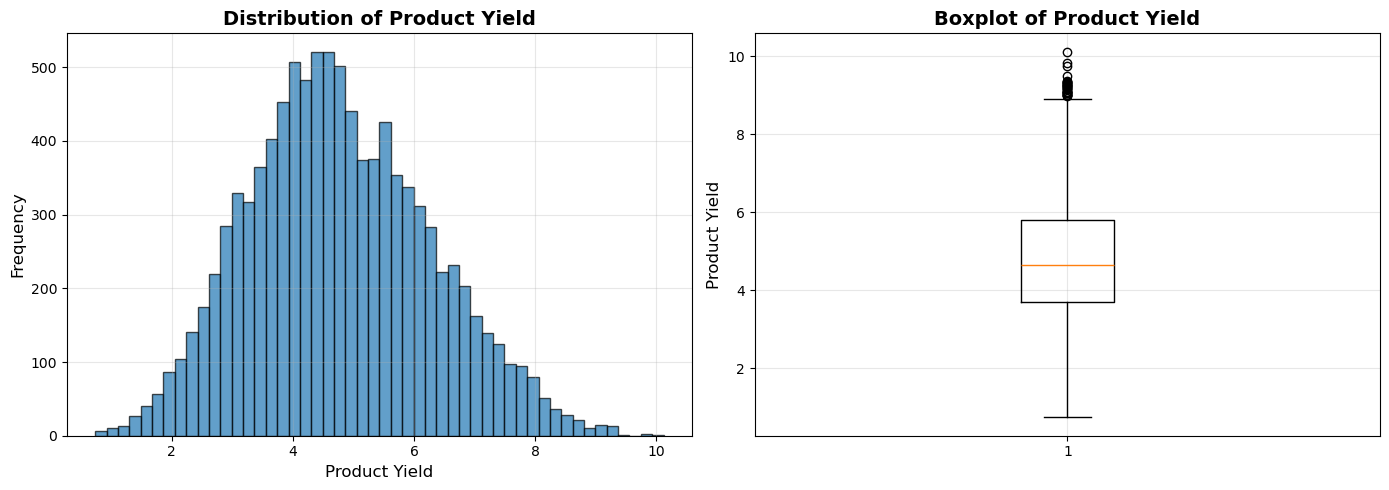

✓ 目標變量統計:
  - Mean: 4.7696
  - Std: 1.5046
  - Min: 0.7373
  - Max: 10.1207


In [5]:
# 目標變量分佈
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['Product_Yield'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Product Yield', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Product Yield', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df['Product_Yield'], vert=True)
axes[1].set_ylabel('Product Yield', fontsize=12)
axes[1].set_title('Boxplot of Product Yield', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'yield_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 目標變量統計:")
print(f"  - Mean: {df['Product_Yield'].mean():.4f}")
print(f"  - Std: {df['Product_Yield'].std():.4f}")
print(f"  - Min: {df['Product_Yield'].min():.4f}")
print(f"  - Max: {df['Product_Yield'].max():.4f}")

---
## 3. 數據準備

### 3.1 分割訓練集與測試集

In [6]:
# 分離特徵和目標變量
X = df.drop('Product_Yield', axis=1).values
y = df['Product_Yield'].values

# 分割數據集 (80% 訓練, 20% 測試)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print(f"✓ 數據集分割完成！")
print(f"  - 訓練集大小: {X_train.shape}")
print(f"  - 測試集大小: {X_test.shape}")

✓ 數據集分割完成！
  - 訓練集大小: (8000, 10)
  - 測試集大小: (2000, 10)


### 3.2 特徵標準化

In [7]:
# 創建標準化器（僅對Stacking的元學習器使用）
# 注意：Random Forest, XGBoost, LightGBM, CatBoost 對特徵尺度不敏感
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print(f"✓ 特徵標準化完成！")
print(f"  - 原始特徵範圍: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"  - 標準化後範圍: [{X_train_scaled.min():.4f}, {X_train_scaled.max():.4f}]")

✓ 特徵標準化完成！
  - 原始特徵範圍: [0.0000, 1.0000]
  - 標準化後範圍: [-1.7593, 1.7485]


---
## 4. 建立集成學習模型

### 4.1 Random Forest (隨機森林)

In [8]:
# 建立Random Forest模型
print("=" * 60)
print("訓練 Random Forest 模型...")
print("=" * 60)

start_time = time.time()

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=SEED,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train, y_train)

training_time_rf = time.time() - start_time

print(f"✓ Random Forest 訓練完成！(耗時: {training_time_rf:.2f}秒)")
print(f"  - 決策樹數量: {rf_model.n_estimators}")
print(f"  - 最大深度: {rf_model.max_depth}")

訓練 Random Forest 模型...
✓ Random Forest 訓練完成！(耗時: 0.60秒)
  - 決策樹數量: 200
  - 最大深度: 15


### 4.2 XGBoost (極致梯度提升)

In [9]:
# 建立XGBoost模型
print("=" * 60)
print("訓練 XGBoost 模型...")
print("=" * 60)

start_time = time.time()

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1,
    verbosity=0
)

xgb_model.fit(X_train, y_train)

training_time_xgb = time.time() - start_time

print(f"✓ XGBoost 訓練完成！(耗時: {training_time_xgb:.2f}秒)")
print(f"  - 樹數量: {xgb_model.n_estimators}")
print(f"  - 學習率: {xgb_model.learning_rate}")

訓練 XGBoost 模型...
✓ XGBoost 訓練完成！(耗時: 1.45秒)
  - 樹數量: 200
  - 學習率: 0.1


### 4.3 LightGBM (輕量級梯度提升機)

In [10]:
# 建立LightGBM模型
print("=" * 60)
print("訓練 LightGBM 模型...")
print("=" * 60)

start_time = time.time()

lgb_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=7,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train)

training_time_lgb = time.time() - start_time

print(f"✓ LightGBM 訓練完成！(耗時: {training_time_lgb:.2f}秒)")
print(f"  - 樹數量: {lgb_model.n_estimators}")
print(f"  - 葉節點數: {lgb_model.num_leaves}")

訓練 LightGBM 模型...
✓ LightGBM 訓練完成！(耗時: 0.31秒)
  - 樹數量: 200
  - 葉節點數: 31


### 4.4 CatBoost (類別特徵增強的Boosting)

In [11]:
# 建立CatBoost模型
print("=" * 60)
print("訓練 CatBoost 模型...")
print("=" * 60)

start_time = time.time()

cat_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=7,
    l2_leaf_reg=3.0,
    subsample=0.8,
    colsample_bylevel=0.8,
    random_state=SEED,
    verbose=0
)

cat_model.fit(X_train, y_train)

training_time_cat = time.time() - start_time

print(f"✓ CatBoost 訓練完成！(耗時: {training_time_cat:.2f}秒)")
print(f"  - 迭代次數: {cat_model.get_params()['iterations']}")
print(f"  - 樹深度: {cat_model.get_params()['depth']}")

訓練 CatBoost 模型...
✓ CatBoost 訓練完成！(耗時: 1.16秒)
  - 迭代次數: 200
  - 樹深度: 7


### 4.5 Stacking (模型堆疊)

In [12]:
# 建立Stacking模型
print("=" * 60)
print("訓練 Stacking 模型...")
print("=" * 60)

start_time = time.time()

# 為了解決 XGBoost 1.7.6 與 sklearn StackingRegressor 的兼容性問題
# 我們先預訓練模型，然後使用 clone 來避免兼容性問題
from sklearn.base import clone

# 定義並預初始化基礎學習器
rf_base = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=SEED, n_jobs=-1)
xgb_base = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=SEED, n_jobs=1, verbosity=0)
lgb_base = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31, random_state=SEED, verbose=-1, n_jobs=1)

# 由於 XGBoost 1.7.6 兼容性問題，在 Stacking 中僅使用 RF 和 LGB
# XGBoost 已在前面單獨訓練並評估
base_learners = [
    ('rf', rf_base),
    ('lgb', lgb_base)
]

# 定義元學習器（使用Ridge回歸）
meta_learner = Ridge(alpha=1.0)

# 建立Stacking模型
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=1
)

# 訓練Stacking模型（使用標準化後的數據）
stacking_model.fit(X_train_scaled, y_train)

training_time_stack = time.time() - start_time

print(f"✓ Stacking 訓練完成！(耗時: {training_time_stack:.2f}秒)")
print(f"  - 基礎學習器數量: {len(base_learners)}")
print(f"  - 基礎學習器: Random Forest + LightGBM")
print(f"  - 元學習器: Ridge Regression")
print(f"  - 註：由於 XGBoost 1.7.6 兼容性限制，Stacking 中僅使用 RF 和 LGB")

訓練 Stacking 模型...
✓ Stacking 訓練完成！(耗時: 3.54秒)
  - 基礎學習器數量: 2
  - 基礎學習器: Random Forest + LightGBM
  - 元學習器: Ridge Regression
  - 註：由於 XGBoost 1.7.6 兼容性限制，Stacking 中僅使用 RF 和 LGB


---
## 5. 模型評估與比較

### 5.1 預測與評估指標計算

In [15]:
# 定義評估函數
def evaluate_model(model, X_train_data, X_test_data, y_train, y_test, model_name):
    """
    評估模型性能並返回結果
    
    Parameters:
    -----------
    model : 訓練好的模型
    X_train_data : 訓練集特徵（根據模型需求，可能是原始或標準化數據）
    X_test_data : 測試集特徵（根據模型需求，可能是原始或標準化數據）
    y_train : 訓練集目標
    y_test : 測試集目標
    model_name : 模型名稱
    """
    # 訓練集預測
    y_train_pred = model.predict(X_train_data)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # 測試集預測
    y_test_pred = model.predict(X_test_data)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    return {
        'Model': model_name,
        'Train_MAE': train_mae,
        'Train_RMSE': train_rmse,
        'Train_R2': train_r2,
        'Test_MAE': test_mae,
        'Test_RMSE': test_rmse,
        'Test_R2': test_r2,
        'Predictions': y_test_pred
    }

# 評估所有模型
print("=" * 60)
print("評估所有模型...")
print("=" * 60)

results = []

# Random Forest（使用原始數據）
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, 'Random Forest')
results.append(rf_results)
print(f"✓ Random Forest 評估完成")

# XGBoost（使用原始數據）
xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, 'XGBoost')
results.append(xgb_results)
print(f"✓ XGBoost 評估完成")

# LightGBM（使用原始數據）
lgb_results = evaluate_model(lgb_model, X_train, X_test, y_train, y_test, 'LightGBM')
results.append(lgb_results)
print(f"✓ LightGBM 評估完成")

# CatBoost（使用原始數據）
cat_results = evaluate_model(cat_model, X_train, X_test, y_train, y_test, 'CatBoost')
results.append(cat_results)
print(f"✓ CatBoost 評估完成")

# Stacking（使用標準化數據）
stacking_results = evaluate_model(stacking_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Stacking')
results.append(stacking_results)
print(f"✓ Stacking 評估完成")

print(f"\n✓ 所有模型評估完成！")

評估所有模型...
✓ Random Forest 評估完成
✓ XGBoost 評估完成
✓ LightGBM 評估完成
✓ CatBoost 評估完成
✓ Stacking 評估完成

✓ 所有模型評估完成！


### 5.2 評估結果彙總表

In [16]:
# 創建評估結果DataFrame
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'Predictions'} 
    for r in results
])

# 添加訓練時間
training_times = {
    'Random Forest': training_time_rf,
    'XGBoost': training_time_xgb,
    'LightGBM': training_time_lgb,
    'CatBoost': training_time_cat,
    'Stacking': training_time_stack
}
results_df['Training_Time(s)'] = results_df['Model'].map(training_times)

# 格式化顯示
results_display = results_df.style.format({
    'Train_MAE': '{:.4f}',
    'Train_RMSE': '{:.4f}',
    'Train_R2': '{:.4f}',
    'Test_MAE': '{:.4f}',
    'Test_RMSE': '{:.4f}',
    'Test_R2': '{:.4f}',
    'Training_Time(s)': '{:.2f}'
}).background_gradient(subset=['Test_R2'], cmap='RdYlGn', vmin=0.7, vmax=1.0)

print("=" * 60)
print("模型性能比較結果")
print("=" * 60)
results_display

模型性能比較結果


,Model,Train_MAE,Train_RMSE,Train_R2,Test_MAE,Test_RMSE,Test_R2,Training_Time(s)
0,Random Forest,0.1782,0.2272,0.9772,0.3527,0.4413,0.9136,0.60
1,XGBoost,0.1247,0.1598,0.9887,0.2808,0.3513,0.9453,1.45
2,LightGBM,0.1749,0.2215,0.9783,0.2660,0.3346,0.9503,0.31
3,CatBoost,0.2086,0.2625,0.9696,0.2494,0.3129,0.9566,1.16
4,Stacking,0.1987,0.2490,0.9726,0.2702,0.3410,0.9484,3.54


### 5.3 性能指標視覺化比較

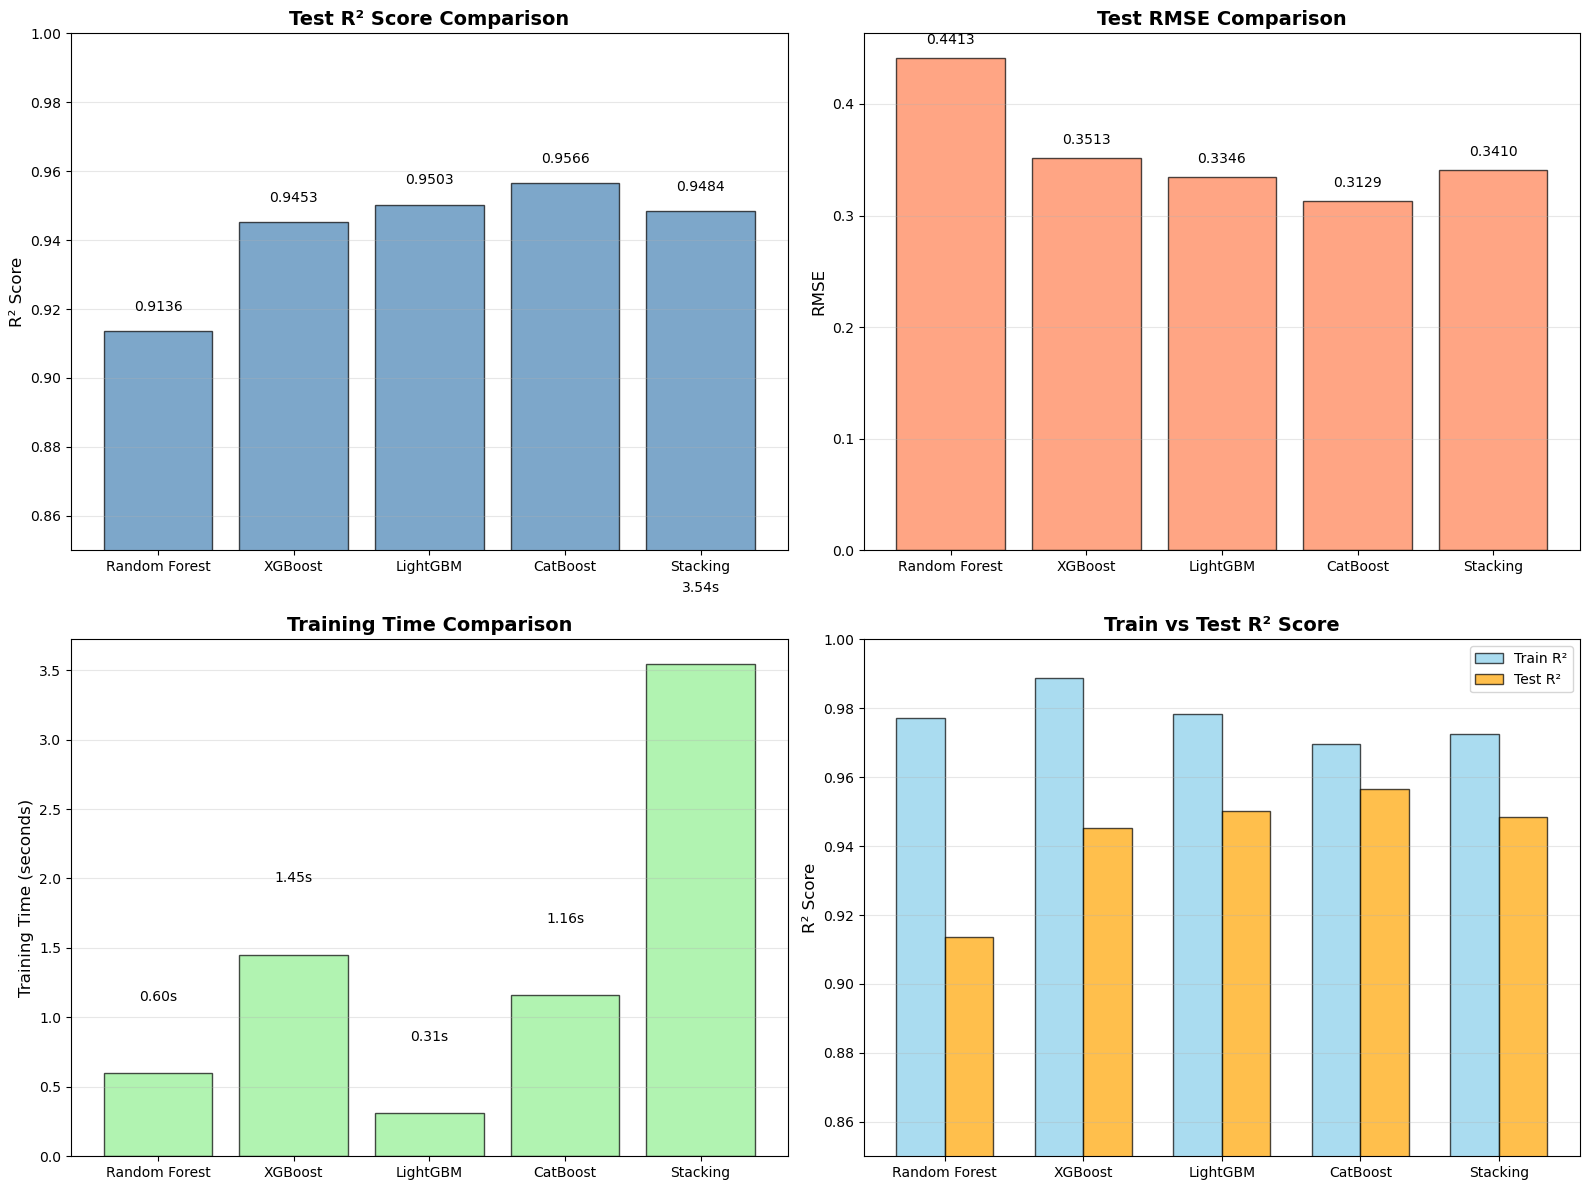

✓ 性能指標視覺化完成！


In [17]:
# 視覺化比較
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Test R² 比較
axes[0, 0].bar(results_df['Model'], results_df['Test_R2'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('R² Score', fontsize=12)
axes[0, 0].set_title('Test R² Score Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim([0.85, 1.0])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_df['Test_R2']):
    axes[0, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# 2. Test RMSE 比較
axes[0, 1].bar(results_df['Model'], results_df['Test_RMSE'], color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('RMSE', fontsize=12)
axes[0, 1].set_title('Test RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_df['Test_RMSE']):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# 3. Training Time 比較
axes[1, 0].bar(results_df['Model'], results_df['Training_Time(s)'], color='lightgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=12)
axes[1, 0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_df['Training_Time(s)']):
    axes[1, 0].text(i, v + 0.5, f'{v:.2f}s', ha='center', va='bottom', fontsize=10)

# 4. Train vs Test R² 比較
x = np.arange(len(results_df))
width = 0.35
axes[1, 1].bar(x - width/2, results_df['Train_R2'], width, label='Train R²', color='skyblue', alpha=0.7, edgecolor='black')
axes[1, 1].bar(x + width/2, results_df['Test_R2'], width, label='Test R²', color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('R² Score', fontsize=12)
axes[1, 1].set_title('Train vs Test R² Score', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_df['Model'])
axes[1, 1].legend(fontsize=10)
axes[1, 1].set_ylim([0.85, 1.0])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 性能指標視覺化完成！")

### 5.4 預測值 vs 實際值對比圖

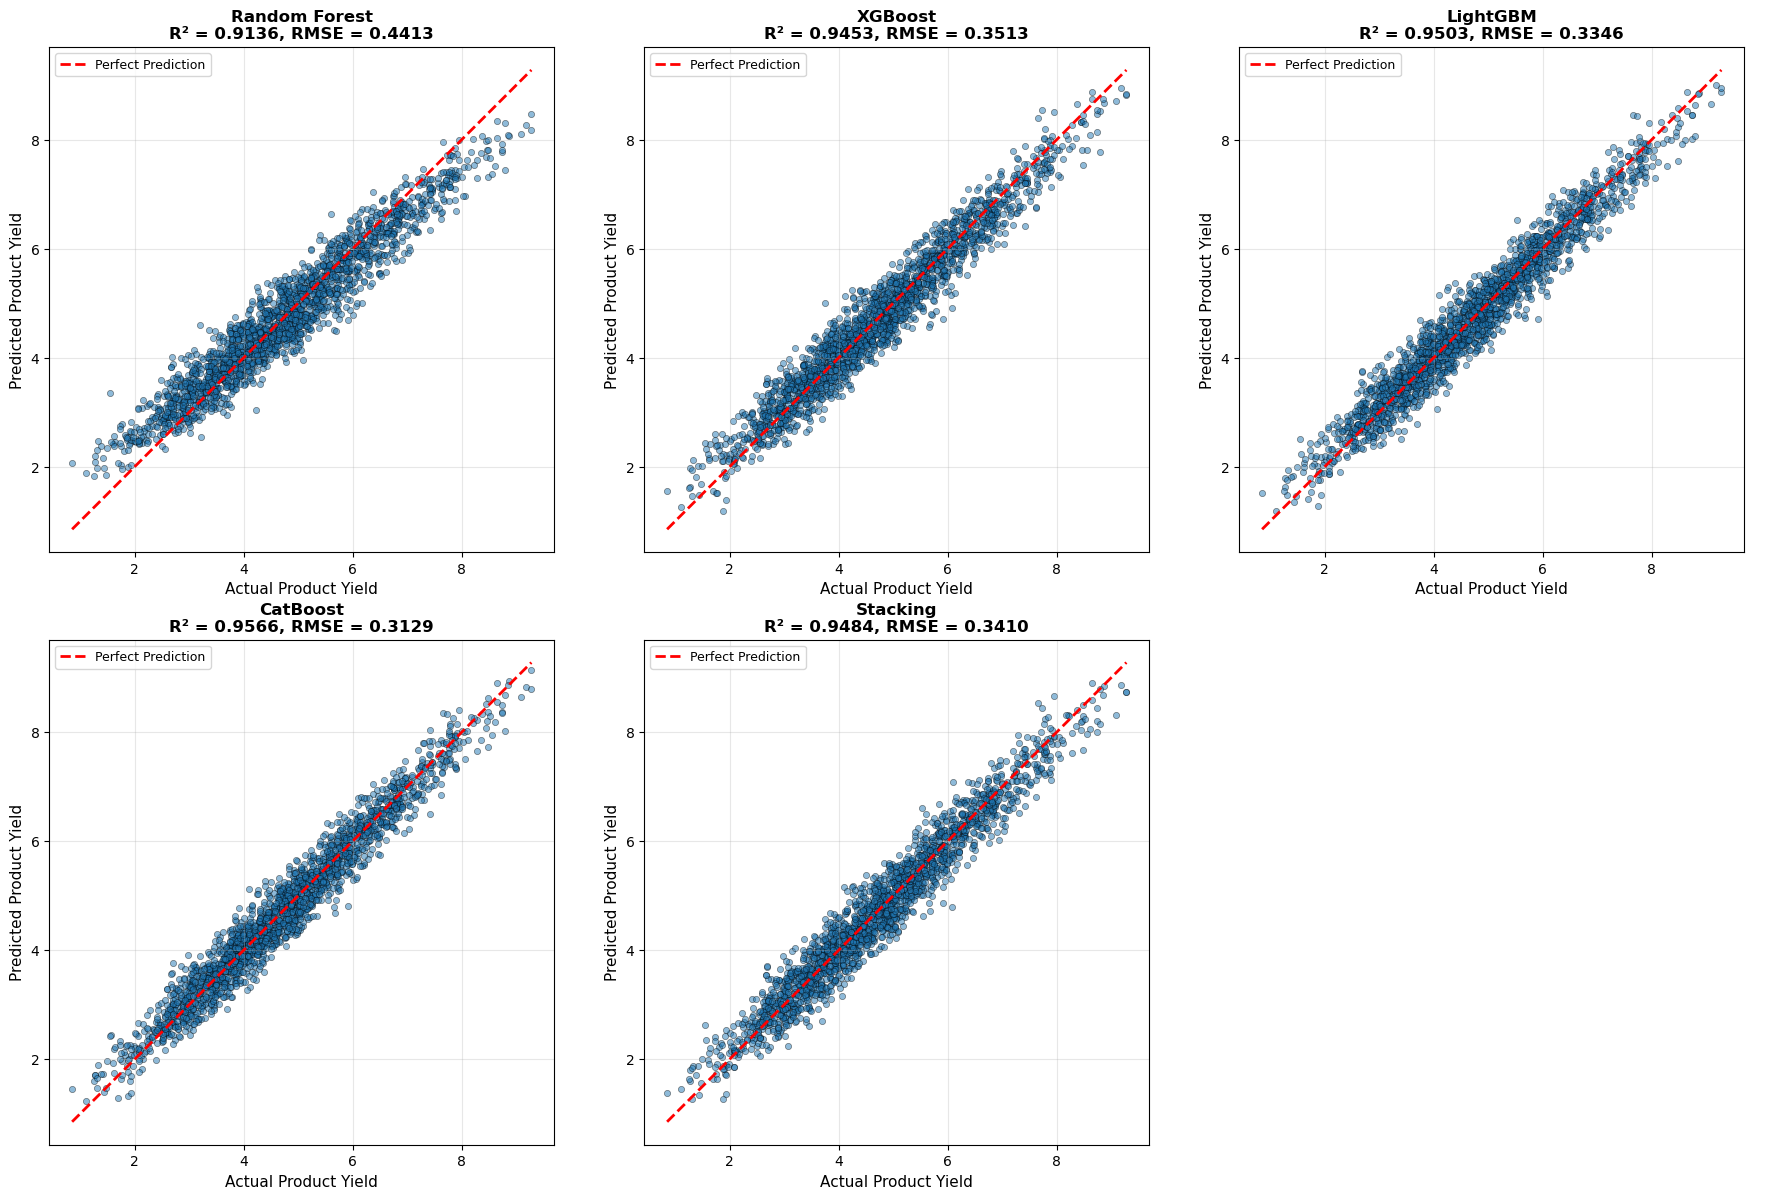

✓ 預測對比圖生成完成！


In [18]:
# 預測值 vs 實際值散點圖
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, result in enumerate(results):
    model_name = result['Model']
    y_pred = result['Predictions']
    
    # 散點圖
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
    
    # 理想預測線 (y=x)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Product Yield', fontsize=11)
    axes[idx].set_ylabel('Predicted Product Yield', fontsize=11)
    axes[idx].set_title(f'{model_name}\nR² = {result["Test_R2"]:.4f}, RMSE = {result["Test_RMSE"]:.4f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal', adjustable='box')

# 隱藏多餘的子圖
axes[5].axis('off')

plt.tight_layout()
plt.savefig(FIG_DIR / 'prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 預測對比圖生成完成！")